In [3]:
# !pip install pandas scikit-learn matplotlib alibi "numpy<2" h2o


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import h2o 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import os

In [19]:
from alibi.explainers import PartialDependence, plot_pd, AnchorTabular

### Set working directory

In [3]:
os.chdir("C:/Users/Sebastian's work/OneDrive - OptiMedis AG/Dokumente/Coding/High-Cost-patient-analysis")

## CREATE SIMPLE TEST MODEL
**File**: test_model.R 

**Author**: Sebastian Benno Veuskens 

**Date**: 2024-07-10

**Data**: Create a small data set with simple relations. 

The purpose of this script is to create a model that is easy to debug.
The model will be used for proof-of-concepts of the explanation methods. 

### Only modify code in the following section

In [4]:
# Number of samples 
n = 500
# Percentage of positive outcomes in label y
percentage = 0.5
# Type of output to use
binary = True 
# Type of model to use 
model_name = 'rf'
# Name of the label
label_name = 'y'

### Generate data

In [5]:
np.random.seed(12345)
x1 = np.random.normal(1, 5, n)
x2 = np.random.normal(-1, 2, n)
err = np.random.normal(0, 20, n)
y = x1 ** 2 + x2 ** 4 + x1 * x2 + err
outcome = np.where(y < np.quantile(y, percentage), 0, 1)
data_con = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
data_bin = pd.DataFrame({'x1': x1, 'x2': x2, 'y': outcome})

# Divide into train and test
train_con, test_con = train_test_split(data_con, test_size=0.25, random_state=12345)
train_bin, test_bin = train_test_split(data_bin, test_size=0.25, random_state=12345)

if binary:
    train = train_bin
    test = test_bin
else:
    train = train_con
    test = test_con

### Model training & prediction

#### H2O 

In [6]:
h2o.init()
train_h2o = h2o.H2OFrame(train_bin)
test_h2o = h2o.H2OFrame(test_bin)
train_h2o[label_name] = train_h2o[label_name].asfactor()
test_h2o[label_name] = test_h2o[label_name].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 day 19 hours 14 mins
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,13 days
H2O_cluster_name:,H2O_from_python_Sebastian_s_work_c4khhm
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.593 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [7]:
model_h2o = h2o.estimators.H2ORandomForestEstimator(seed=12345,
                                                   ntrees=1000,
                                                   mtries=2)
                                                   
cov_names = set(train_h2o.names).difference(label_name)
model_h2o.train(x=cov_names,
               y=label_name,
               training_frame=train_h2o
)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1721550699056_1204


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    1000               1000                        542984                 9            17           11.824        24            52            38.413

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.10418052937235533
RMSE: 0.32277008748078767
LogLoss: 0.5466631288636548
Mean Per-Class Error: 0.1091224675620305
AUC: 0.9289921465968587
AUCPR: 0.9267018867697423
Gini: 0.8579842931937174

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36344086618134475
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      168  23   0.1204   (23.0/191.0)
1      18   166  0.0978   (18.0/184.0)
Total  186  189  0.1093   (41.0/375.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.363441     0.89008   134
max f2                       0.0840336    0.901222  190
max f0point5                 0.363441     0.882979  134
max accuracy                 0.363441     0.890667  134
max precision                0.999489     0.9875    28
max recall                   0            1         282
max specificity              1            0.994764  0
max absolute_mcc             0.363441     0.781644  134
max min_per_class_accuracy   0.403183     0.879581  130
max mean_per_class_accuracy  0.363441     0.890878  134
max tns                      1            190       0
max fns                      1            139       0
max fps                      0            191       282
max tps                      0            184       282
max tnr                      1            0.994764  0
max fnr                      1            0.755435  0
max fpr                      0            1         282
max tpr                      0            1         282

Gains/Lift Table: Avg response rate: 49.07 %, avg score: 48.67 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.122667                    1                  1.99374    1.99374            0.978261         1            0.978261                    1                   0.244565        0.244565                   99.3738   99.3738            0.23933
2        0.152                       0.999826           2.03804    2.00229            1                0.99983      0.982456                    0.999967            0.0597826       0.304348                   103.804   100.229            0.299112
3        0.2                         0.999649           2.03804    2.01087            1                0.999782     0.986667                    0.999923            0.0978261       0.402174                   103.804   101.087            0.396938
4        0.301333                    0.977858           1.71625    1.91179            0.842105         0.992516     0.938053                    0.997432            0.173913        0.576087                   71.6247   91.1793            0.539438
5        0.4                         0.773101           1.65247    1.84783            0.810811         0.906854     0.906667                    0.97

In [8]:
predictions = h2o.as_list(model_h2o.predict(test_h2o)[:,2])

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\h2o\frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


#### scikit-learn

In [58]:
if model_name == "rf":
    model_sck = RandomForestClassifier(n_estimators=1000, max_features=2, random_state=12345)
elif model_name == "lr":
    model_sck = LogisticRegression(random_state=12345)

model_sck.fit(train[['x1', 'x2']], train['y'])

predictions = model_sck.predict_proba(test[['x1', 'x2']])[:,1]

### Model evaluation
#### ROC curve

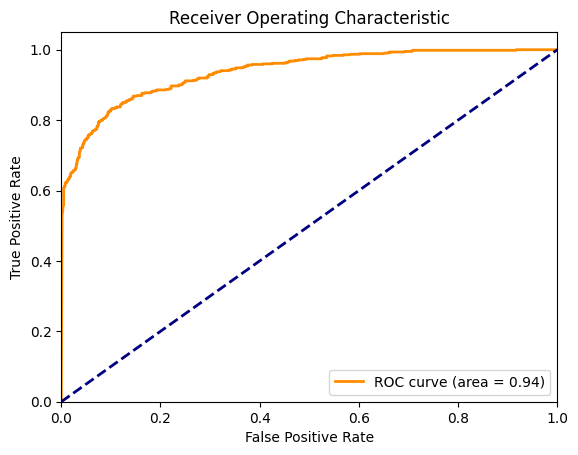

In [91]:
fpr, tpr, _ = roc_curve(test['y'], predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Precision-Recall curve

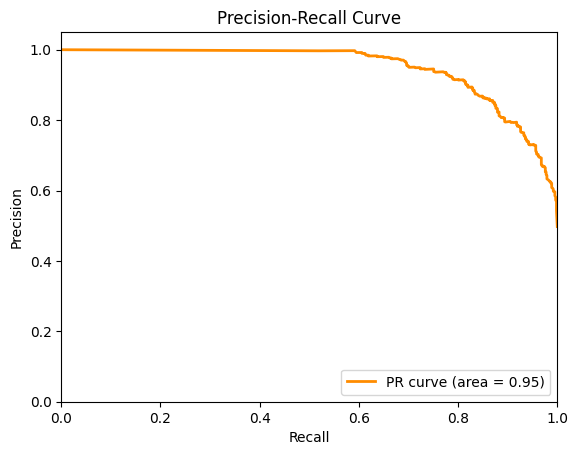

In [18]:
precision, recall, _ = precision_recall_curve(test['y'], predictions)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

#### Confusion matrix

In [19]:
conf_matrix = confusion_matrix(test['y'], model.predict(test[['x1', 'x2']]))
print(conf_matrix)

[[553  75]
 [103 519]]


# XAI methods

## Alibi


### PDP & ICE

In [91]:
show_pdp = True

In [92]:
# TODO: Find better solution for column_names
def predict_fn_h2o_pdp(x):
    x = h2o.H2OFrame(x, column_names=list(test.columns))
    preds = model_h2o.predict(x)
    return h2o.as_list(preds)

def predict_fn_sck_pdp(x):
    return model_sck.predict(x[:,:2])

features = [0, 1]
sample = test[list(cov_names)].iloc[1]

In [93]:
kind = 'average' if show_pdp else 'both'
predict_fn_pdp = predict_fn_sck_pdp
pdp = PartialDependence(predictor=predict_fn_pdp,
                        feature_names=['x1', 'x2'],
                        target_names=['y'])
exp20 = pdp.explain(X=test.values,
                  features=features,
                  kind=kind)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

array([[<Axes: xlabel='x1', ylabel='y'>, <Axes: xlabel='x2', ylabel='y'>]],
      dtype=object)

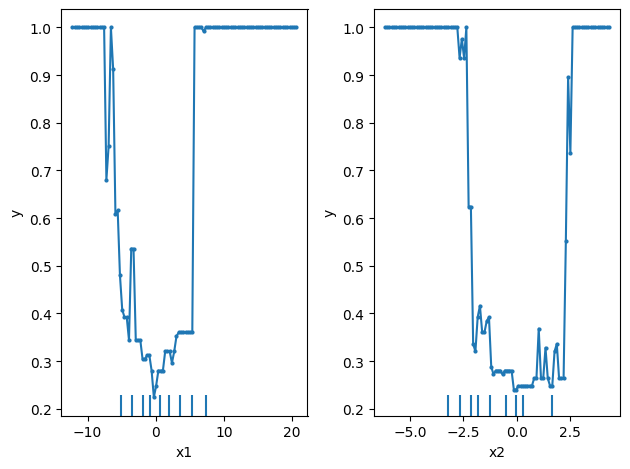

In [94]:
plot_pd(exp20,
        n_cols=2,
        sharey='row',
        center=show_pdp)

### Anchors

In [ ]:
# TODO: Find better solution for column_names
def predict_fn_h2o_anchors(x):
    x = h2o.H2OFrame(x, column_names=list(test.columns))
    preds = model_h2o.predict(x)
    return h2o.as_list(preds).values

def predict_fn_sck_anchors(x):
    return model_sck.predict(x)

In [ ]:
predict_fn_anchors = predict_fn_sck_anchors
exp_anchors = AnchorTabular(predict_fn_anchors, features)
exp_anchors.fit(train[list(cov_names)].values, disc_perc=(25, 50, 75))
res_anchors = exp_anchors.explain(sample.values, threshold=0.75)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

In [ ]:
res_anchors.data


{'anchor': ['0 > 4.20'],
 'precision': 0.8,
 'coverage': 0.2499,
 'raw': {'feature': [0],
  'mean': [0.8],
  'precision': [0.8],
  'coverage': [0.2499],
  'examples': [{'covered_true': array([[ 6.22956267, -0.78468512],
           [ 7.5150654 ,  2.15789583],
           [ 7.09977182, -0.96829705],
           [ 4.45000926, -2.86068341],
           [ 7.7486307 , -0.89578664],
           [ 5.31290041, -2.6355306 ],
           [17.2447196 ,  0.26863328],
           [10.82890286, -3.98186483],
           [ 9.34512655,  1.43891486],
           [ 9.736168  , -1.82528339]]),
    'covered_false': array([[ 4.73216519, -2.03375646],
           [ 5.31142024, -1.64074019],
           [ 4.84511284, -0.70463768],
           [ 5.55491321, -1.76082795],
           [ 5.56207076, -0.99926194],
           [ 5.61974209,  0.20741043],
           [ 4.97626578,  1.17669517],
           [ 5.25906754,  0.20666931],
           [ 4.60597169, -1.52828284],
           [ 4.63684391, -1.75099563]]),
    'uncovered_tru

## scikit-learn

## H2O